In [1]:
DATASET = 'kits'    # 'amos' or 'flare' or 'kits'
FOLD = 0



from monai.utils import set_determinism
from monai.transforms import AsDiscrete
# from networks.UXNet_3D.network_backbone import UXNET
# from networks.msHead_3D.network_backbone import MSHEAD_ATTN
# from monai.networks.nets import UNETR, SwinUNETR
# from networks.nnFormer.nnFormer_seg import nnFormer
# from networks.TransBTS.TransBTS_downsample8x_skipconnection import TransBTS
from monai.metrics import DiceMetric
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, decollate_batch, ThreadDataLoader

import torch
from torch.utils.tensorboard import SummaryWriter
from load_datasets_transforms import data_loader, data_transforms
import matplotlib.pyplot as plt

import os
import numpy as np
from tqdm import tqdm
import datetime
import argparse
import time

In [3]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

# Create the config object from the dictionary
config_dict = {
    'root': './data/' + DATASET,
    'output': '/orange/r.forghani/results',
    'dataset': DATASET,
    'network': 'MSHEAD',
    'mode': 'test',
    'pretrain': False,
    'pretrained_weights': '/orange/r.forghani/results/09-11-24_1805/model_best.pth',
    'batch_size': 1,
    'crop_sample': 2,
    'lr': 0.0001,
    'optim': 'AdamW',
    'max_iter': 40000,
    'eval_step': 500,
    'resume': False,
    'finetune': True,
    'gpu': 0,
    'cache_rate': 1.0,
    'num_workers': 8,
    'start_index': 160,
    'end_index': 180,
    'no_split': False,
    'plot': False
}

if DATASET == 'kits':
    config_dict['fold'] = FOLD

# Instantiate the Config class
config = Config(config_dict)

# Access the parameters as needed
print("Root Directory:", config.root)
print("Network:", config.network)
print("Batch Size:", config.batch_size)

# # Example usage within a function or class
# def train_model(config):
#     print(f"Training {config['network']} on {config['dataset']} dataset with batch size {config['batch_size']}...")
#     # Add your training logic here

# # Run the function with the configuration
# train_model(config)


Root Directory: ./data/kits
Network: MSHEAD
Batch Size: 1


In [4]:

if config.dataset == 'amos':
    ORGAN_CLASSES = {1: "Spleen", 2: "Right Kidney", 3: "Left Kidney", 4: "Gall Bladder", 5: "Esophagus",6: "Liver",
        7: "Stomach", 8: "Aorta", 9: "Inferior Vena Cava", 10: "Pancreas", 11: "Right Adrenal Gland", 
        12: "Left Adrenal Gland", 13: "Duodenum", 14: "Bladder", 15: "Prostate"}
    voxel_volume = 1.5 * 1.5 * 2.0  # mm^3
elif config.dataset == 'flare':
    ORGAN_CLASSES = {1: "Liver", 2: "Kidney", 3: "Spleen", 4: "Pancreas"}
    voxel_volume = 1.0 * 1.0 * 1.2  # mm^3
elif config.dataset == 'kits':
    ORGAN_CLASSES = {1: "Kidney", 2: "Tumor"}
else:
    raise ValueError("Invalid dataset name")


test_samples, out_classes = data_loader(config)

Start to load data from directory: ./data/kits
dataset: kits
Finished loading all inference samples from dataset: kits!


In [1]:
test_files = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(test_samples['images'], test_samples['labels'])
]
print(f'test files: {len(test_files)}')

# Set determinism for reproducibility
set_determinism(seed=0)

# Apply data transforms using the config object
test_transforms = data_transforms(config)
print('Start caching datasets!')

# Initialize the cache dataset and data loader
test_ds = CacheDataset(
    data=test_files, 
    transform=test_transforms, 
    cache_rate=config.cache_rate, 
    num_workers=config.num_workers
)
test_loader = ThreadDataLoader(test_ds, batch_size=1, num_workers=0)

# Set the device for PyTorch operations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'--- device: {device} ---')



NameError: name 'test_samples' is not defined

In [5]:

for step, batch in enumerate(test_loader):
    test_inputs, test_labels = (batch["image"].to(device), batch["label"].to(device))
    print(f'---------------------{step}---------------------')
    print(f'input: {test_inputs.shape} labels:{test_labels.shape}')     # B,C,D,H,W format: D slices in each CT data
                                                                        #each slice has 1 channel-> C = 1
                                                                        # for validation loader B = 1 too.
                                                                        # So, 1,1,D,H,W
                                                                        # H, W and D will be different for each CT
                                                                        # we need to calculate shape-wise result on
                                                                        # validation set. So, here we take the full image
                                                                        # to calculate volume for each organ.
                                                                        # To calculate volume we can use labels from
                                                                        # val_labels. How? That's where I need help
    test_labels = test_labels.numpy()
    test_labels = test_labels[0, 0, :, :, :]
    unique_labels = np.unique(test_labels)
    print(f'unique labels: {unique_labels}')
    for label in unique_labels:
        if label == 0.0:  # Skip background
            continue
        dummy = np.zeros(shape=test_labels.shape, dtype='uint8')
        dummy[test_labels==label] = 1
        N_voxel = np.count_nonzero(dummy)
        volume = N_voxel * voxel_volume    # in mm^3
        volume = volume/1000                # in cm^3
        print(f'Class: {ORGAN_CLASSES[label]} volume: {volume}')
    print(f'---------------------{step}---------------------COMPLETED')


---------------------0---------------------
input: torch.Size([1, 1, 399, 286, 401]) labels:torch.Size([1, 1, 399, 286, 401])
unique labels: [0. 1. 2. 3. 4.]
Class: Liver volume: 1093.8192
Class: Kidney volume: 330.984
Class: Spleen volume: 139.1004
Class: Pancreas volume: 164.6976
---------------------0---------------------COMPLETED
---------------------1---------------------
input: torch.Size([1, 1, 349, 257, 151]) labels:torch.Size([1, 1, 349, 257, 151])
unique labels: [0. 1. 2. 3. 4.]
Class: Liver volume: 1283.454
Class: Kidney volume: 256.80719999999997
Class: Spleen volume: 170.1816
Class: Pancreas volume: 85.7748
---------------------1---------------------COMPLETED
---------------------2---------------------
input: torch.Size([1, 1, 329, 273, 193]) labels:torch.Size([1, 1, 329, 273, 193])
unique labels: [0. 1. 2. 3. 4.]
Class: Liver volume: 1515.9396
Class: Kidney volume: 260.4348
Class: Spleen volume: 729.3444000000001
Class: Pancreas volume: 54.5004
---------------------2-----

In [6]:
import pandas as pd
import numpy as np

# Initialize a DataFrame with class labels as columns
class_labels = [ORGAN_CLASSES[label] for label in sorted(ORGAN_CLASSES.keys())]
df = pd.DataFrame(columns=class_labels)

# Iterate over the test loader and fill the DataFrame with volumes
for step, batch in enumerate(test_loader):
    # Move tensors to device and convert to numpy
    test_inputs, test_labels = batch["image"].to(device), batch["label"].to(device)
    print(f'---------------------{step}---------------------')
    # print(f'input: {test_inputs.shape} labels: {test_labels.shape}')
    
    # Extract label data and find unique labels
    test_labels = test_labels.cpu().numpy()[0, 0, :, :, :]
    unique_labels = np.unique(test_labels)
    # print(f'unique labels: {unique_labels}')
    
    # Initialize a dictionary to store volumes for the current sample
    volume_dict = {label_name: np.nan for label_name in class_labels}

    # Calculate volumes for each unique label (excluding background)
    for label in unique_labels:
        if label == 0.0:  # Skip background
            continue
        
        dummy = np.zeros(shape=test_labels.shape, dtype='uint8')
        dummy[test_labels == label] = 1
        N_voxel = np.count_nonzero(dummy)
        volume = N_voxel * voxel_volume  # in mm^3
        volume /= 1000  # Convert to cm^3

        # Store the volume in the dictionary
        volume_dict[ORGAN_CLASSES[label]] = volume

    # Append the volume dictionary as a new row in the DataFrame
    df = pd.concat([df, pd.DataFrame([volume_dict])], ignore_index=True)


---------------------0---------------------
---------------------1---------------------
---------------------2---------------------
---------------------3---------------------
---------------------4---------------------
---------------------5---------------------
---------------------6---------------------
---------------------7---------------------
---------------------8---------------------
---------------------9---------------------
---------------------10---------------------
---------------------11---------------------
---------------------12---------------------
---------------------13---------------------
---------------------14---------------------
---------------------15---------------------
---------------------16---------------------
---------------------17---------------------
---------------------18---------------------
---------------------19---------------------


In [7]:
# Calculate and print min and max for each class
print("\nMin and Max Volumes for Each Class:")
for label in class_labels:
    min_volume = df[label].min(skipna=True)  # Skip NaN values
    max_volume = df[label].max(skipna=True)  # Skip NaN values
    print(f"{label}: Min = {min_volume:.2f} cm^3, Max = {max_volume:.2f} cm^3")


Min and Max Volumes for Each Class:
Liver: Min = 958.26 cm^3, Max = 2297.14 cm^3
Kidney: Min = 226.06 cm^3, Max = 648.29 cm^3
Spleen: Min = 117.62 cm^3, Max = 764.10 cm^3
Pancreas: Min = 32.64 cm^3, Max = 217.42 cm^3


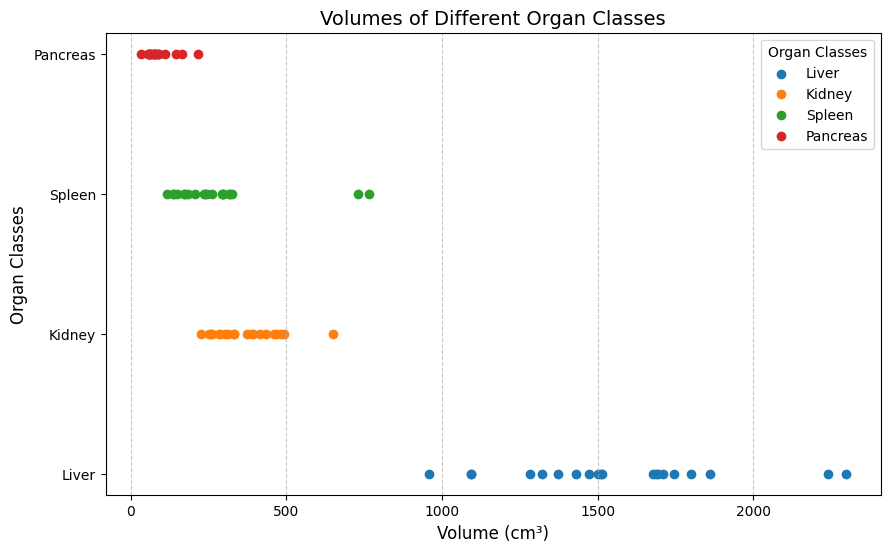

In [8]:
# Plotting volumes with different colors for each class
plt.figure(figsize=(10, 6))

for label in class_labels:
    plt.scatter(df[label], [label] * len(df), label=label)

plt.xlabel("Volume (cm³)", fontsize=12)
plt.ylabel("Organ Classes", fontsize=12)
plt.title("Volumes of Different Organ Classes", fontsize=14)
plt.legend(title="Organ Classes")
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [9]:
# df.head()
means = df.mean()
std_devs = df.std()
means.sort_values(ascending=False, inplace=True)
means

Liver       5864.015700
Kidney      1387.256400
Spleen      1048.913775
Pancreas     325.680075
dtype: float64

In [10]:
std_devs.sort_values(ascending=False, inplace=True)
std_devs

Liver       1293.783040
Spleen       648.778412
Kidney       398.335308
Pancreas     162.757219
dtype: float64

In [11]:
# Save the DataFrame to a CSV file
csv_filename = f'organ_volumes_{config.dataset}.csv'
df.to_csv(csv_filename, index=False)
print(f'CSV file saved as {csv_filename}')

CSV file saved as organ_volumes_flare.csv


In [12]:

    ############# For Visualization. Do u have to do it? No. For understanding, you can.

    ############ 
    
    # Before Visualization using matplotlib, you need to convert those tensor to numpy arrays.
    # numpy arrays will be B,C,D,H,W format. Convert it to B,C,H,W,D format for your convenience(your wish)
                               
                                # Or
    
    # You can remove the last line in val_transforms under "args.dataset==amos" in load_datasets_transforms.py
    # last line --> ToTensord(keys=["image", "label"]).
    # if you remove this line data will be automatically in B,C,H,W,D format and probably as numpy array.
    # Then you can plot it directly

    #############
    
    # plt.figure("check", (18, 6))
    # plt.subplot(1, 2, 1)
    # plt.title(f"image {i}")
    # plt.imshow(val_inputs["image"][0, 0, :, :, 80], cmap="gray")     # pass a D value to visualize a slice. Here D=80
    # plt.subplot(1, 2, 2)
    # plt.title(f"label {i}")
    # plt.imshow(val_inputs["label"][0, 0, :, :, 80])
    # # plt.subplot(1, 3, 3)
    # # plt.title(f"output {i}")
    # # plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
    # plt.show()
    # if i == 2:
    #     break
    ##############################

